# Appendix
## Data importation/ formatting

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import timedelta
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from logitplots import plt_confusion_matrix
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

In [3]:
with open("Melbourne01.txt") as f:
    txt = f.read()
    for i in range(20):
        txt = txt.replace("\t", " ")
        txt = txt.replace("  ", " ")
    txt = txt.split("\n")
    for row_idx in range(len(txt)):
        if len(txt[row_idx]) > 0 and txt[row_idx][0] == " ":
            txt[row_idx] = txt[row_idx][1:]


for row_idx in range(len(txt)):
    txt[row_idx] = txt[row_idx].split(" ")
txt_df = pd.DataFrame(data=txt)


cols = ["year", "month", "day", "hour", "minute", "air_temp", "apparent_temp", "dew_pt_temp", "humidity", "wind_direction", "wind_speed", "wind_gust", "mslp", "rainfall_9am", "blank"]

txt_df.columns = cols
txt_df.drop(labels="blank", axis=1, inplace=True) # extra col?
txt_df.drop(labels=1019654, inplace=True) # extra row?
txt_df.drop_duplicates(inplace=True)
txt_df.reset_index(inplace=True)
txt_df.drop(labels="index", axis=1, inplace=True)

df = txt_df # re-alias txt_df to df for usability
del txt_df


indices = df[df["mslp"] == "0.0"].index
for index in indices:
    sub = df.iloc[index]
    sub["wind_direction"], sub["wind_speed"], sub["wind_gust"], sub["mslp"], sub["rainfall_9am"] = None, None, None, sub["wind_direction"], None

df.replace(to_replace="-", value=np.NaN, inplace=True)
df.replace(to_replace="-9999", value=np.NaN, inplace=True)
df.replace(to_replace="-9999.0", value=np.NaN, inplace=True)

# converting all number columns (even integer columns like datetimes, humidity, mslp) data to float
float_cols = ["year", "month", "day", "hour", "minute", "air_temp", "apparent_temp", "dew_pt_temp", "humidity", "wind_speed", "wind_gust", "mslp", "rainfall_9am"]
for col in float_cols:
    df[col] = df[col].astype(np.float64)

#method for finding cartesian values for speed
def wind_dir_to_cartesian(radii, dir_texts):
    # optimised for speed, takes vector inputs.
    original_idx = radii.index
    dir_texts_sub = dir_texts.dropna()
    radii_sub = radii.dropna()
    idxs = radii_sub.index.intersection(dir_texts_sub.index)
    na_idxs = original_idx[np.logical_or(radii.isna(), dir_texts.isna())] # filtering out NA values

    dir_texts_sub = dir_texts_sub[idxs]
    radii_sub = radii_sub[idxs]
    
    a = 2*np.pi/16
    angle_dict = {"N":4*a,"NNE":3*a,"NE":2*a,"ENE":1*a,"E":0,"ESE":15*a,"SE":14*a,"SSE":13*a,"S":12*a,"SSW":11*a,"SW":10*a,"WSW":9*a,"W":8,"WNW":7*a,"NW":6*a,"NNW":5*a, "CALM":0, "NaN":None}
    angles = pd.DataFrame(angle_dict, index=[0])[dir_texts_sub].loc[0].to_numpy()

    
    X, Y = radii_sub*np.cos(angles), radii_sub*np.sin(angles)
    
    X_speed = radii.copy()
    X_speed.iloc[:] = np.NaN
    
    Y_speed = radii.copy()
    Y_speed.iloc[:] = np.NaN

    X_speed[np.logical_not(np.logical_or(radii.isna(), dir_texts.isna()))] = X


    Y_speed[np.logical_not(np.logical_or(radii.isna(), dir_texts.isna()))] = Y
    X_speed.name = "X_speed"
    Y_speed.name = "Y_speed"
    return X_speed, Y_speed

# converting angle+speed wind to xspeed+yspeed
wind_vecs_rectangular = wind_dir_to_cartesian(df["wind_speed"], df["wind_direction"])
df = df.join(wind_vecs_rectangular)
del wind_vecs_rectangular

# converting datetime columns to a column of datetimes, then dropping
timestamp = pd.to_datetime(df[["year", "month", "day", "hour", "minute"]])
timestamp.name = "timestamp"
df.index = timestamp
df.drop(labels=["year", "month", "day", "hour", "minute"], axis=1, inplace=True)
del timestamp


In [4]:
# creating rainfall_diff
rainfall_diff = df["rainfall_9am"].diff()
rainfall_diff[rainfall_diff < 0] = 0
rainfall_diff.name = "rainfall_diff"
df = df.join(rainfall_diff)
df.loc[df.index[0], "rainfall_diff"] = 0
del rainfall_diff

In [5]:
# resampling by day
rainfall_df = df['rainfall_9am']
rainfall_df.index = rainfall_df.index - timedelta(hours = 9)
wind_gust_df = df['wind_gust']
df = df.drop(['rainfall_9am','wind_gust'],axis=1).resample('D').mean()
df['rainfall_9am'] = rainfall_df.resample('D').max()
df['wind_gust'] = wind_gust_df.resample('D').max()
df = df.interpolate(method="time")

In [6]:
#iterative method for finding/ ravelling data from three days prior to an entry
class long_lookup:
    def __init__(self, df, window_size):
        self.df = df
        self.window_size = window_size
        self.index = np.arange(len(self.df)-self.window_size+1)
    
    def __getitem__(self, get_idx):
        start = get_idx
        end = start + self.window_size
        try:
            return self.df.loc[start:end]
        except TypeError:
            return self.df.iloc[start:end]
    
    def __iter__(self):
        class iterator:
            def __init__(self, obj):
                self.obj = obj
                self.iterator = iter(range(len(obj.df)-obj.window_size+1))
                return None
            def __next__(self):
                idx = next(self.iterator)
                return self.obj[idx]
                
        return iterator(self)
    
    def iter_index(self, idxs):
        class iterator:
            def __init__(self, obj):
                self.obj = obj
                self.iterator = iter(idxs)
                return None
            def __iter__(self):
                return self
            def __next__(self):
                idx = next(self.iterator)
                return self.obj[idx]
                
        return iterator(self)

## Exploratory Data Analysis
### Correlations

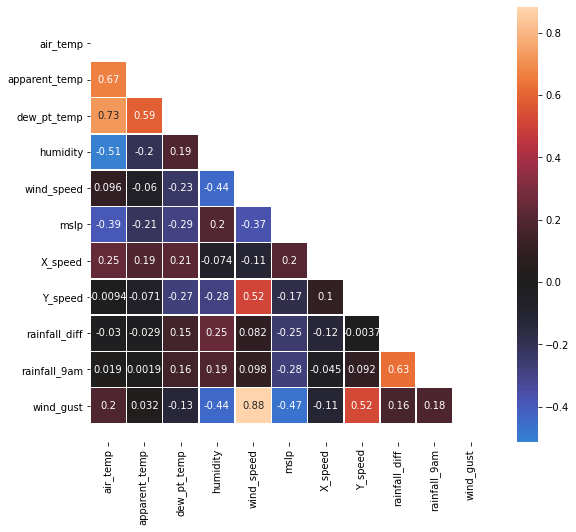

In [9]:
corrs = df.corr()
mask = np.triu(np.ones_like(corrs, dtype=np.bool)) 
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corrs, mask=mask, center=0, annot=True, square=True, linewidths=.5) 
bottom, top = ax.get_ylim() 
ax.set_ylim(bottom + 0.5, top - 0.5);

Text(0.5, 1.0, 'y wind speed vs air temperature')

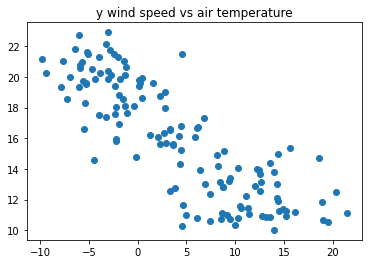

In [10]:
#plot for temperature 
X = df.index
Y = df.resample("M").mean()
plt.scatter(Y["Y_speed"], Y["air_temp"])
plt.title("y wind speed vs air temperature")

Text(0.5, 1.0, 'monthly average temperature')

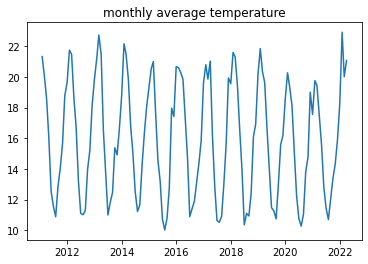

In [11]:
#plot for temperature 
plt.plot(Y.index, Y["air_temp"])
plt.title("monthly average temperature")

Text(0.5, 1.0, 'monthly average temperature')

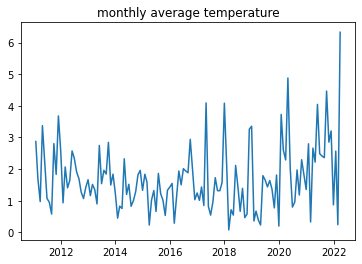

In [12]:
#plot for rainfall
plt.plot(Y.index, Y["rainfall_9am"])
plt.title("monthly average temperature")

## Modelling

In [13]:
scores_df = pd.DataFrame()

### Binary

In [14]:
window_size = 3
long_day_df = long_lookup(df, window_size+1)
train_idxs, test_idxs = train_test_split(long_day_df.index, train_size=0.8)

target_feature = "rainfall_9am"

X_train = np.array([long_day_df[idx][:window_size].values.ravel() for idx in train_idxs])
y_train = np.array([long_day_df[idx][target_feature].iloc[window_size] > 0.2 for idx in train_idxs])

X_test = np.array([long_day_df[idx][:window_size].values.ravel() for idx in test_idxs])
y_test = np.array([long_day_df[idx][target_feature].iloc[window_size]  > 0.2 for idx in test_idxs])

for x in [X_train, y_train, X_test, y_test]:
    x = (x - x.mean())/x.std()

In [15]:
linreg = LinearRegression()
linreg = linreg.fit(X_train, y_train)
linreg_bin_score = linreg.score(X_test, y_test)
print(linreg_bin_score)

0.16767020739250393


In [16]:
logreg = LogisticRegression()
logreg = logreg.fit(X_train, y_train)
logreg_bin_score = logreg.score(X_test, y_test)
print(logreg_bin_score)

0.7184822521419829


In [17]:
nests = np.arange(150, 200, 5)
results = np.zeros((len(nests)))
for i in range(len(nests)):
    random_forest = RandomForestClassifier(n_estimators=nests[i]).fit(X_train, y_train)
    results[i] = random_forest.score(X_test, y_test)                   

results_df = pd.DataFrame(results, columns = ['accuracy score'],index=nests)
randf_bin_score = results_df.loc[results_df['accuracy score']==results_df['accuracy score'].max()].reset_index().loc[0]['accuracy score']
print(randf_bin_score)

0.7405140758873929


### Multi-category 

In [18]:
rain_bins = pd.IntervalIndex.from_tuples([(-0.1, 0.2),(0.2,5),(5, 10),(10,25),(25,60)])

binned_df = df.copy()
binned_df['bins'] = pd.cut(df['rainfall_9am'], rain_bins)
binned_df['bins'] = binned_df['bins'].astype('str')
binned_df['bins'] = binned_df['bins'].replace({'(-0.1, 0.2]':0,'(0.2, 5.0]':1,'(5.0, 10.0]':2,'(10.0, 25.0]':3,'(25.0, 60.0]':4})

window_size = 3
long_day_df = long_lookup(binned_df, window_size+1)
target_feature = "bins"

X_train = np.array([long_day_df[idx][:window_size].values.ravel() for idx in train_idxs])
y_train = np.array([long_day_df[idx][target_feature].iloc[window_size] for idx in train_idxs])

X_test = np.array([long_day_df[idx][:window_size].values.ravel() for idx in test_idxs])
y_test = np.array([long_day_df[idx][target_feature].iloc[window_size] for idx in test_idxs])

for x in [X_train, y_train, X_test, y_test]:
    x = (x - x.mean())/x.std()

In [19]:
linreg = LinearRegression()
linreg = linreg.fit(X_train, y_train)
linreg_m_score = linreg.score(X_test, y_test)
print(linreg_m_score)

0.12923528079279012


In [20]:
logreg = LogisticRegression()
logreg = logreg.fit(X_train, y_train)
logreg_m_score = logreg.score(X_test, y_test)
print(logreg_m_score)

0.6915544675642595


In [21]:
nests = np.arange(150, 200, 5)
results = np.zeros((len(nests)))
for i in range(len(nests)):
    random_forest = RandomForestClassifier(n_estimators=nests[i]).fit(X_train, y_train)
    results[i] = random_forest.score(X_test, y_test)                   

results_df = pd.DataFrame(results, columns = ['accuracy score'],index=nests)
randf_m_score = results_df.loc[results_df['accuracy score']==results_df['accuracy score'].max()].reset_index().loc[0]['accuracy score']
print(randf_m_score)

0.7074663402692778


### SMOTE
#### Binary

In [22]:
window_size = 3
target_feature = "rainfall_9am"

X = np.array([long_day_df[idx][:window_size].values.ravel() for idx in long_day_df.index])
y = np.array([long_day_df[idx][target_feature].iloc[window_size] > 0.2 for idx in long_day_df.index])

sm = SMOTE(random_state=2)
sm_df= sm.fit_resample(pd.DataFrame(X), pd.DataFrame(y))

X_train,X_test,y_train,y_test=train_test_split(sm_df[0],sm_df[1],train_size=0.8,random_state=0)
for x in [X_train, y_train, X_test, y_test]:
    x = (x - x.mean())/x.std()

In [23]:
linreg = LinearRegression()
linreg = linreg.fit(X_train, y_train)
linreg_bin_smote_score = linreg.score(X_test, y_test)
print(linreg_bin_smote_score)

0.15375282802767487


In [24]:
logreg = LogisticRegression()
logreg = logreg.fit(X_train, y_train)
logreg_bin_smote_score = logreg.score(X_test, y_test)
print(logreg_m_score)

0.6915544675642595


In [25]:
nests = np.arange(150, 200, 5)
results = np.zeros((len(nests)))
for i in range(len(nests)):
    random_forest = RandomForestClassifier(n_estimators=nests[i]).fit(X_train, y_train)
    results[i] = random_forest.score(X_test, y_test)                   

results_df = pd.DataFrame(results, columns = ['accuracy score'],index=nests)
randf_bin_smote_score = results_df.loc[results_df['accuracy score']==results_df['accuracy score'].max()].reset_index().loc[0]['accuracy score']
print(randf_bin_smote_score)

0.7840805123513266


#### Multi category

In [26]:
window_size = 3
target_feature = "bins"

long_day_df = long_lookup(binned_df, window_size+1)

X = [long_day_df[idx][:window_size].values.ravel() for idx in long_day_df.index]
y = [long_day_df[idx][target_feature].iloc[window_size] for idx in long_day_df.index]

sm = SMOTE(random_state=2)
sm_df = sm.fit_resample(pd.DataFrame(X), pd.DataFrame(y))

X_train,X_test,y_train,y_test=train_test_split(sm_df[0],sm_df[1],train_size=0.8,random_state=0)
for x in [X_train, y_train, X_test, y_test]:
    x = (x - x.mean())/x.std()

In [27]:
linreg = LinearRegression()
linreg = linreg.fit(X_train, y_train)
linreg_m_smote_score = linreg.score(X_test, y_test)
print(linreg_m_smote_score)

0.25334365713656926


In [28]:
logreg = LogisticRegression()
logreg = logreg.fit(X_train, y_train)
logreg_m_smote_score = logreg.score(X_test, y_test)
print(logreg_m_smote_score)

0.35444891980959353


In [29]:
nests = np.arange(150, 200, 5)
results = np.zeros((len(nests)))
for i in range(len(nests)):
    random_forest = RandomForestClassifier(n_estimators=nests[i]).fit(X_train, y_train)
    results[i] = random_forest.score(X_test, y_test)                   

results_df = pd.DataFrame(results, columns = ['accuracy score'],index=nests)
randf_m_smote_score = results_df.loc[results_df['accuracy score']==results_df['accuracy score'].max()].reset_index().loc[0]['accuracy score']


In [30]:
scores = pd.DataFrame({'names':['linear regression','linear regression','logistic regression','logistic regression','random forest','random forest','linear regression','linear regression','logistic regression','logistic regression','random forest','random forest'],
                      'problem type':['binary','multi-category','binary','multi-category','binary','multi-category','binary','multi-category','binary','multi-category','binary','multi-category'], 
                      'smote/no smote':['no SMOTE','no SMOTE','no SMOTE','no SMOTE','no SMOTE','no SMOTE','SMOTE','SMOTE','SMOTE','SMOTE','SMOTE','SMOTE'],
                      'score':[linreg_bin_score,linreg_m_score, logreg_bin_score,logreg_m_score, randf_bin_score,randf_m_score,linreg_bin_smote_score,linreg_m_smote_score, logreg_bin_smote_score,logreg_m_smote_score, randf_bin_smote_score, randf_m_smote_score]})
score_table = pd.pivot_table(scores, values='score', index=['names','smote/no smote'],
                    columns=['problem type'], aggfunc=np.sum)
score_table

problem type                          binary  multi-category
names               smote/no smote                          
linear regression   SMOTE           0.153753        0.253344
                    no SMOTE        0.167670        0.129235
logistic regression SMOTE           0.663312        0.354449
                    no SMOTE        0.718482        0.691554
random forest       SMOTE           0.784081        0.922007
                    no SMOTE        0.740514        0.707466